# 製作因子分析表
1. 拉因子進表單中
2. 計算不同decay的IC值
3. 畫不同群的損益(優~劣 / 持有不同天數)

先用樣本內2006~2012，樣本外2013~2022試試看最佳化

In [1]:
import pymongo
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
from typing import Union, Optional


In [2]:
class Factor:

    def __init__(self, client: pymongo.MongoClient, start: datetime.datetime, end: datetime.datetime, db_name: str='Fields'):
        self.client = client
        self.start = start
        self.end = end
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()

        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', 50)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')


    def get_chart(self):
        keys = self.results
        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(6, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'].fillna(0).astype(bool).sum(axis=1)[:-1], color='green')
            ax[2].set_title('累計股數')
        if 'HOLDING' in keys:
            ax[3].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[3].set_title('累計市值')
            ax[3].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[4].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[4].grid(True)
            ax[4].set_title('Rolling Sharpe Ratio')
            ax[4].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[5].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[5].grid(True)
            ax[5].set_title('Capital')
            ax[5].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()

    def get_data_list(self):
        return self.db.list_collection_names()
    
    def get_data(self, name: Union[str, list], start: Optional[datetime.datetime]=None, end: Optional[datetime.datetime]=None, store: bool=True):
        """
        name: str, list 要取得的表單名稱
        
        """
        if start == None:
            start = self.start
        if end == None:
            end = self.end

        if type(name) == list:
            for n in name:
                df = pd.DataFrame(self.db[n].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
                self.data[n] = df
        else:
            df = pd.DataFrame(self.db[name].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
            if store:
                
                self.data[name] = df
            else:
                return df
    
    def create_to_daily(self, df: pd.DataFrame):
        """
        將日以上週期資料轉換為日資料
        """
        if '收盤價' not in self.data.keys():
            self.get_data('收盤價')
        idx = self.data['收盤價'].index
        col = self.data['收盤價'].columns
        n = pd.DataFrame(columns=col.intersection(df.columns), index=idx.union(df.index))
        for i in n.index:
            for c in n.columns:
                try:
                    n.at[i, str(c)] = df.at[i, c]
                except:
                    pass
                
        return n.fillna(method='ffill').loc[idx, col]

    def get_norm_factor(self, name: Union[str, list, pd.DataFrame], growth: bool=False, growth_len: int=1):
        """
        name: 放要抓的factor名稱
        growth: 如果要用pct_change算則=True
        growth_len: 使用pct_change計算幾個位移差距
        """
        if type(name) == list:
            for n in name:
                if n in self.data.keys():
                    df = self.data[n]
                else:
                    df = pd.DataFrame(self.db[n].find({"日期": {'$gt': self.start, '$lt': self.end}}, {'_id': 0})).set_index('日期')
        elif type(name) == pd.DataFrame:
            df = name
        else:
            if name in self.data.keys():
                df = self.data[name]
            else:
                df = pd.DataFrame(self.db[name].find({"日期": {'$gt': self.start, '$lt': self.end}}, {'_id': 0})).set_index('日期')
        if growth:
            df = df.pct_change(growth_len).replace(np.inf, 0.1).replace(-np.inf, -0.1)
        return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0).replace([np.inf, -np.inf], 0)

    def get_ic(self, df: pd.DataFrame, pct_len: int=20, decay: int=1):
        """
        df: 放要算IC的資料
        pct_len: 與df計算IC的還原收盤價，是用多長時間的報酬，DEFAULT:20 = 一個月報酬
        decay: 位移距離，DEFAULT=1表示移一格
        """
        if '還原收盤價' in self.data.keys():
            close = self.data['還原收盤價']
        else:
            close = pd.DataFrame(self.db['還原收盤價'].find({"日期": {'$gt': self.start, '$lt': self.end}}, {'_id': 0})).set_index('日期')
        idx = df.index.intersection(close.index)
        col = df.columns.intersection(close.columns)
        df_ = df.copy()
        df_ = df_.loc[idx, col]
        close = close.loc[idx, col].pct_change(pct_len).shift(-decay)
        ic = df_.corrwith(close, axis=1)
        
        return ic


In [3]:
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2013, 9, 30)
factor = Factor(pymongo.MongoClient(), start=start, end=end, db_name='Fields')
factor.get_data(['開盤價', '最高價', '最低價', '還原收盤價'], store=True)

factors = {
    'EPS_Q': factor.create_to_daily(factor.get_norm_factor('EPS_Q', growth=True, growth_len=4)),
    '營業收入淨額_Q': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Q', growth=True, growth_len=4)),
    '殖利率': factor.get_norm_factor('殖利率'),
    '股價淨值比': factor.get_norm_factor('股價淨值比'),
    '本益比': factor.get_norm_factor('本益比(近四季)'),
    '成交金額(千)': factor.get_norm_factor('成交金額(千)'),
    'EBITDA_Q': factor.create_to_daily(factor.get_norm_factor('EBITDA_Q', growth=True, growth_len=4)),
    '槓桿比率_Q': factor.create_to_daily(factor.get_norm_factor('槓桿比率_Q', growth=True, growth_len=4)),
    '現金股利殖利率_Y': factor.create_to_daily(factor.get_norm_factor('現金股利殖利率_Y', growth=False)),
    '現金流量比率_Q': factor.create_to_daily(factor.get_norm_factor('現金流量比率_Q', growth=True, growth_len=4)),
    '總資產週轉次數_Y': factor.create_to_daily(factor.get_norm_factor('總資產週轉次數_Y', growth=False)),
}

In [4]:

multifactor_m = sum(factors.values()).groupby(pd.Grouper(freq='1m')).tail(1)
ic_multifactor = factor.get_ic(multifactor_m, pct_len=1, decay=1)
ir = ic_multifactor.mean() / ic_multifactor.std()

In [34]:
for k, v in factors.items():
    ic_multifactor = factor.get_ic(v.groupby(pd.Grouper(freq='1q')).tail(1), pct_len=1, decay=1)
    ir = ic_multifactor.mean() / ic_multifactor.std()
    print(k, 'mean: {:.4f} std: {:.4f}'.format(ic_multifactor.mean(), ir))
    

EPS_Q mean: 0.0015 std: 0.0443
營業收入淨額_Q mean: 0.0066 std: 0.1958
殖利率 mean: 0.0114 std: 0.1859
股價淨值比 mean: -0.0402 std: -0.5789
本益比 mean: 0.0017 std: 0.0286
成交金額(千) mean: -0.0322 std: -0.5498
EBITDA_Q mean: -0.0024 std: -0.0658
槓桿比率_Q mean: 0.0219 std: 0.4822
現金股利殖利率_Y mean: -0.0074 std: -0.1151
現金流量比率_Q mean: -0.0117 std: -0.3198
總資產週轉次數_Y mean: -0.0133 std: -0.1868


c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zer

T -0.19 SR: -0.04 SR.cum: -0.65


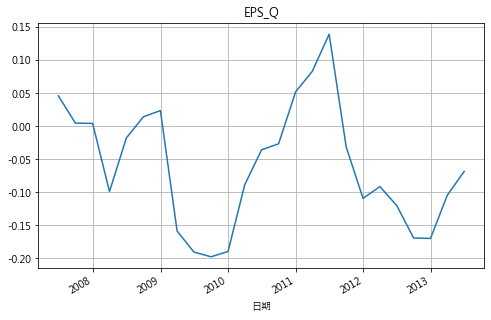

T 0.29 SR: 0.06 SR.cum: 2.03


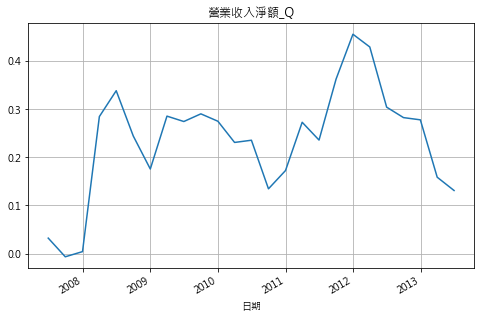

殖利率
股價淨值比
T 0.05 SR: 0.01 SR.cum: 0.56


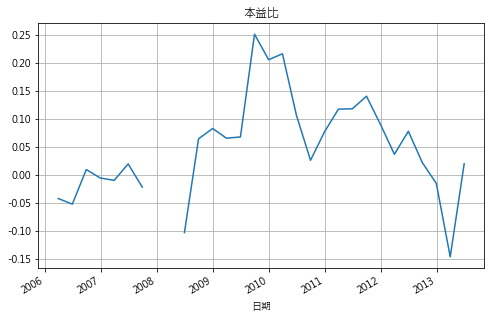

成交金額(千)
T 1.43 SR: 0.29 SR.cum: 2.13


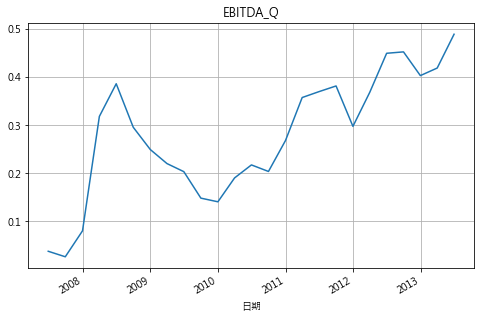

T 0.28 SR: 0.06 SR.cum: -0.23


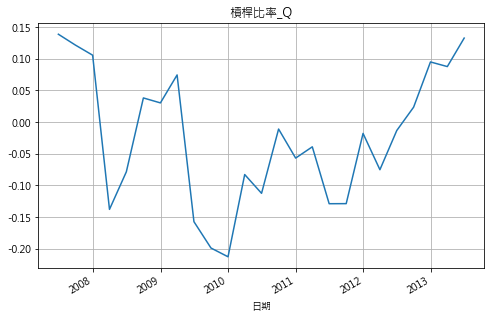

現金股利殖利率_Y
T -0.91 SR: -0.18 SR.cum: -3.80


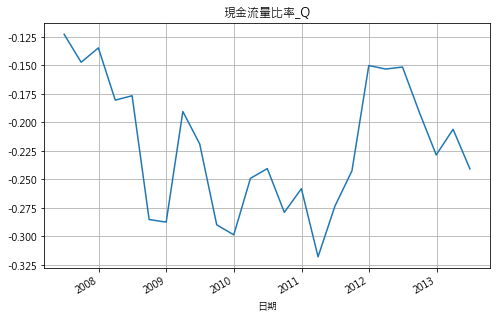

T -0.60 SR: -0.11 SR.cum: -1.19


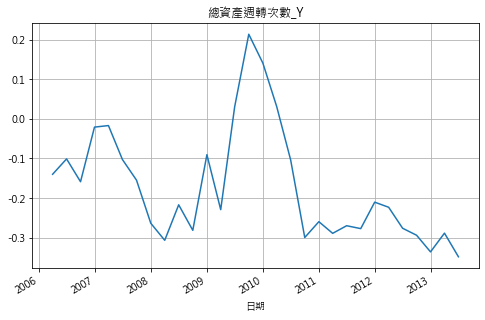

In [35]:
def t_stat(series):
    return series.mean() * np.sqrt(len(series.dropna())) / series.std()
group_names = [str(x) for x in range(1, 51)]
close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1q')).tail(1)#.pct_change().shift(-1)
for c in close_m.columns:
    close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
close_m = close_m.shift(-1)

for k, v in factors.items():
    try:
        df_group_results = pd.DataFrame(index=v.groupby(pd.Grouper(freq='1q')).tail(1).index, columns=group_names)
        for idx, row in v.groupby(pd.Grouper(freq='1q')).tail(1).iterrows():
            # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
            se = pd.Series(close_m.loc[idx, :] - 0.00550, name=idx)
            if len(row.dropna()) >= 5:
                df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 50, labels=group_names)).mean()
        # 買第五群(最高分) 賣第一群(最低分)
        pf = (df_group_results['50'] - df_group_results['1'])
        pf.cumsum().plot(figsize=(8, 5), grid=True, title=str(k))
        t_ratio = t_stat(pf)
        sharpe_ratio = pf.mean() / pf.std()
        sharpe_ratio_cum = pf.cumsum().mean() / pf.cumsum().std()
        print('T {:.2f}'.format(t_ratio), 'SR: {:.2f}'.format(sharpe_ratio), 'SR.cum: {:.2f}'.format(sharpe_ratio_cum))
        plt.show()
    except:
        print(k)
        pass

2022-10-13 16:59:55.780183


c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zer

均數: 0.02
方差: 0.07
Best IR: 0.31
{'EPS_Q': 0, '營業收入淨額_Q': 0, '殖利率': 1, '股價淨值比': 1, '本益比': 0, '成交金額(千)': -1, 'EBITDA_Q': -1, '槓桿比率_Q': 1, '現金股利殖利率_Y': -1, '現金流量比率_Q': 0, '總資產週轉次數_Y': 0}
T 0.07 SR: 0.01 SR.cum: -0.16


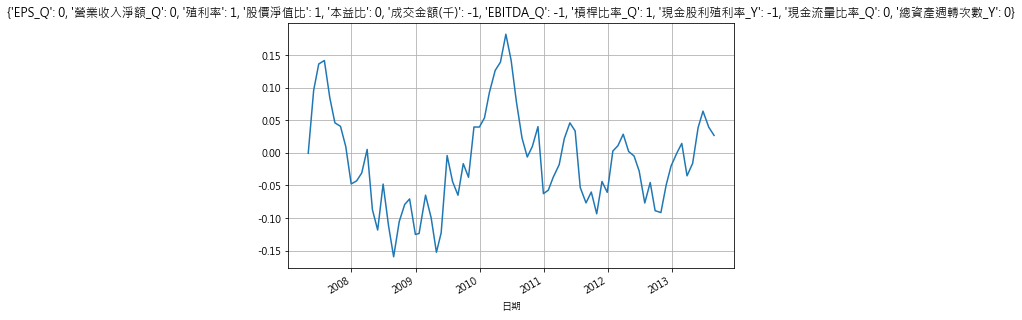

均數: 0.03
方差: 0.06
Best IR: 0.46
{'EPS_Q': -1, '營業收入淨額_Q': 0, '殖利率': 1, '股價淨值比': -1, '本益比': 0, '成交金額(千)': 0, 'EBITDA_Q': -1, '槓桿比率_Q': 0, '現金股利殖利率_Y': -1, '現金流量比率_Q': 0, '總資產週轉次數_Y': 0}
T 1.60 SR: 0.18 SR.cum: 1.37


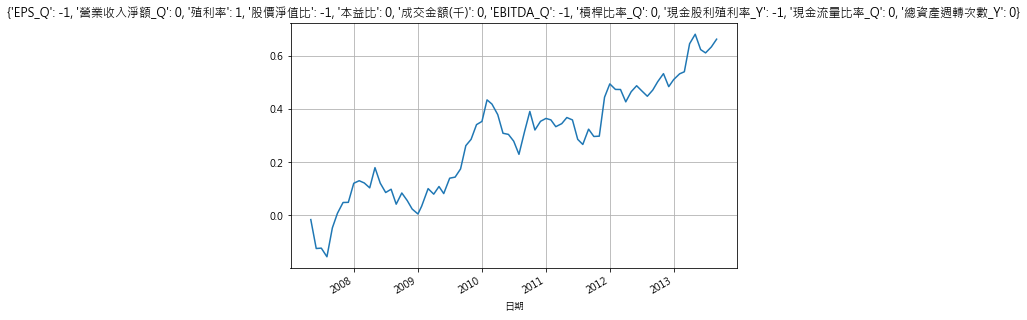

均數: 0.04
方差: 0.06
Best IR: 0.70
{'EPS_Q': 1, '營業收入淨額_Q': 0, '殖利率': 1, '股價淨值比': -1, '本益比': -1, '成交金額(千)': -1, 'EBITDA_Q': 1, '槓桿比率_Q': 1, '現金股利殖利率_Y': -1, '現金流量比率_Q': -1, '總資產週轉次數_Y': 0}
T 2.94 SR: 0.34 SR.cum: 2.18


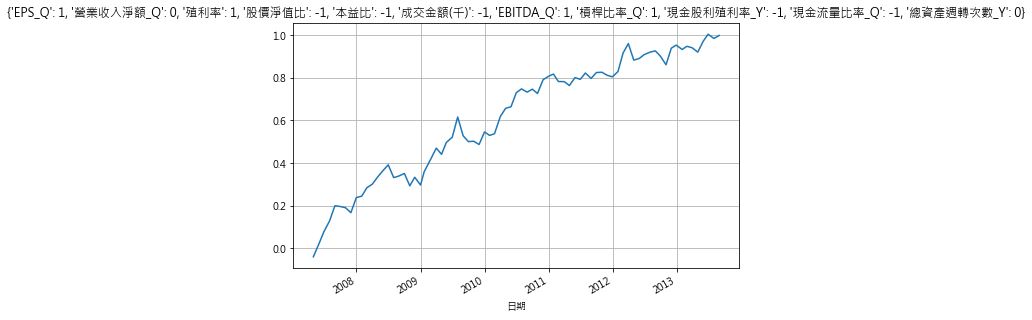

2022-10-13 17:05:20.460406
0.7010516118631439
{'EPS_Q': 1, '營業收入淨額_Q': 0, '殖利率': 1, '股價淨值比': -1, '本益比': -1, '成交金額(千)': -1, 'EBITDA_Q': 1, '槓桿比率_Q': 1, '現金股利殖利率_Y': -1, '現金流量比率_Q': -1, '總資產週轉次數_Y': 0}


In [4]:
def t_stat(series):
    return series.mean() * np.sqrt(len(series.dropna())) / series.std()

print(datetime.datetime.now())
best_ir = 0
best_weights = dict()
best_weights_list = list()
t_list = list()
group_names = [str(x) for x in range(1, 51)]
close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
for c in close_m.columns:
    close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
close_m = close_m.shift(-1)
for _ in range(1000):
    # weights = {
    #     'EPS_Q': np.random.choice([-1, 0, 1, 5]),
    #     '營業收入淨額_Y': np.random.choice([-1, 0, 1, 5]),
    #     '營業收入淨額_Q': np.random.choice([-1, 0, 1, 5]),
    #     '殖利率': np.random.choice([-1, 0, 1, 5]),
    #     '股價淨值比': np.random.choice([-5, -1, 0, 1]),
    #     '本益比': np.random.choice([-5, -1, 0, 1]),
    #     '成交金額(千)': np.random.choice([-1, 0, 1]),
    #     '20MA':  np.random.choice([-1, 0, 1, 5]),
    #     '60MA':  np.random.choice([-1, 0, 1, 5]),
    #     '120MA':  np.random.choice([-1, 0, 1, 5]),
    #     '20STD':  np.random.choice([-5, -1, 0, 1]),
    #     '60STD':  np.random.choice([-5, -1, 0, 1]),
    #     '120STD':  np.random.choice([-5, -1, 0, 1])
    # }
    weights = {
        'EPS_Q': np.random.choice([-1, 0, 1]),
        '營業收入淨額_Q': np.random.choice([-1, 0, 1]),
        '殖利率': np.random.choice([-1, 0, 1]),
        '股價淨值比': np.random.choice([-1, 0, 1]),
        '本益比': np.random.choice([-1, 0, 1]),
        '成交金額(千)': np.random.choice([-1, 0, 1]),
        'EBITDA_Q': np.random.choice([-1, 0, 1]),
        '槓桿比率_Q': np.random.choice([-1, 0, 1]),
        '現金股利殖利率_Y': np.random.choice([-1, 0, 1]),
        '現金流量比率_Q': np.random.choice([-1, 0, 1]),
        '總資產週轉次數_Y': np.random.choice([-1, 0, 1]),
    }
    multifactor = dict()
    for k in factors.keys():
        multifactor[k] = factors[k] * weights[k]
    multifactor_m = sum(multifactor.values()).groupby(pd.Grouper(freq='1m')).tail(1)
    ic_multifactor = factor.get_ic(multifactor_m, pct_len=1, decay=1)
    ir = ic_multifactor.mean() / ic_multifactor.std()
    
    if ir > best_ir:
        best_ir = ir
        best_weights = weights
        best_weights_list.append(weights)
        print('均數: {:.2f}'.format(ic_multifactor.mean()))
        print('方差: {:.2f}'.format(ic_multifactor.std()))
        print('Best IR: {:.2f}'.format(best_ir))
        print(best_weights)
        # 分群計算
        #group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
        #group_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12' ,'13', '14', '15']
        multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
        df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
        for idx, row in multifactor_m.iterrows():
            # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
            se = pd.Series(close_m.loc[idx, :] - 0.00550, name=idx)
            if len(row.dropna()) >= 5:
                df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 50, labels=group_names)).mean()
        # 買第五群(最高分) 賣第一群(最低分)
        pf = (df_group_results['50'] - df_group_results['1'])
        pf.cumsum().plot(figsize=(8, 5), grid=True, title=str(best_weights))
        t_ratio = t_stat(pf)
        t_list.append(t_ratio)
        sharpe_ratio = pf.mean() / pf.std()
        sharpe_ratio_cum = pf.cumsum().mean() / pf.cumsum().std()
        print('T {:.2f}'.format(t_ratio), 'SR: {:.2f}'.format(sharpe_ratio), 'SR.cum: {:.2f}'.format(sharpe_ratio_cum))
        plt.show()
        #df_group_results.cumsum().plot(figsize=(16, 9), grid=True)
print(datetime.datetime.now())
print(best_ir)
print(best_weights)

str(best_weights)

best_weights = {'EPS_Q': 10, '營業收入淨額_Y': 10, '殖利率': 5, '股價淨值比': -5, '本益比': -5, '成交金額(千)': 3, '60MA': 1, '120MA': 1}

In [19]:
start = datetime.datetime(2013, 9, 30)
end = datetime.datetime(2022, 9, 30)
factor = Factor(pymongo.MongoClient(), start=start, end=end, db_name='Fields')
factor.get_data(['開盤價', '最高價', '最低價', '還原收盤價', 'EPS_Q'], store=True)

factors = {
    'EPS_Q': factor.create_to_daily(factor.get_norm_factor('EPS_Q', growth=True, growth_len=4)),
    '營業收入淨額_Y': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Y', growth=True)),
    '營業收入淨額_Q': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Q', growth=True, growth_len=4)),
    '殖利率': factor.get_norm_factor('殖利率'),
    '股價淨值比': factor.get_norm_factor('股價淨值比'),
    '本益比': factor.get_norm_factor('本益比(近四季)'),
    '成交金額(千)': factor.get_norm_factor('成交金額(千)'),
    '20MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(20).mean().pct_change()),
    '60MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(60).mean().pct_change()),
    '120MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(120).mean().pct_change()),
    '20STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(20).std()),
    '60STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(60).std()),
    '120STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(120).std())
}

In [20]:
multifactor = dict()
for k in factors.keys():
    multifactor[k] = factors[k] * best_weights[k]

<AxesSubplot:xlabel='日期'>

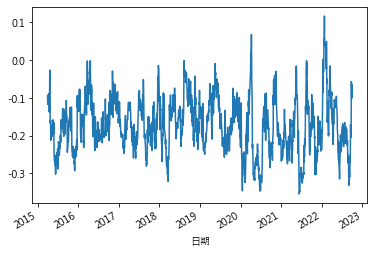

In [21]:
ic_multifactor = factor.get_ic(sum(multifactor.values()), pct_len=20)
ic_multifactor.plot()

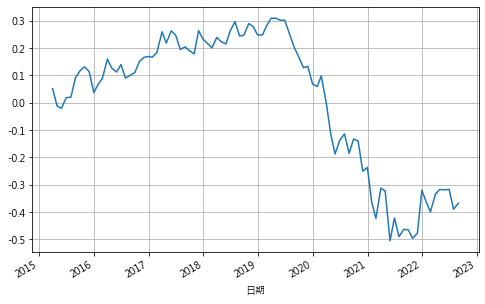

T值: -0.73, T值與樣本內差異: -2.36


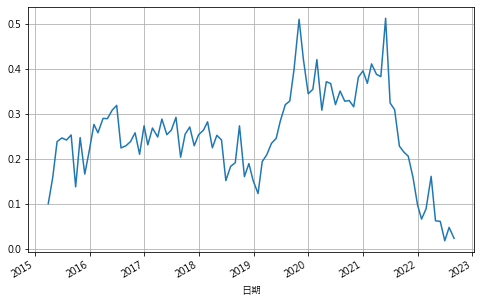

T值: 0.04, T值與樣本內差異: -0.46


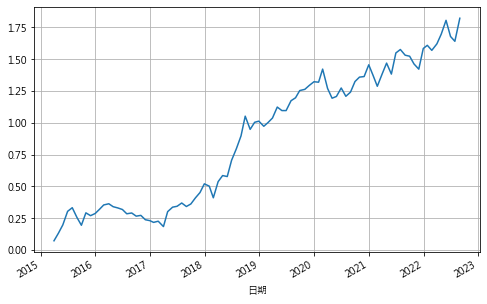

T值: 2.85, T值與樣本內差異: -1.48


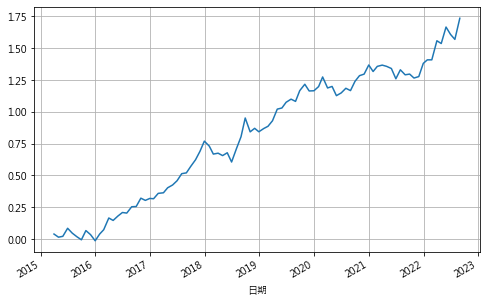

T值: 3.38, T值與樣本內差異: 0.31


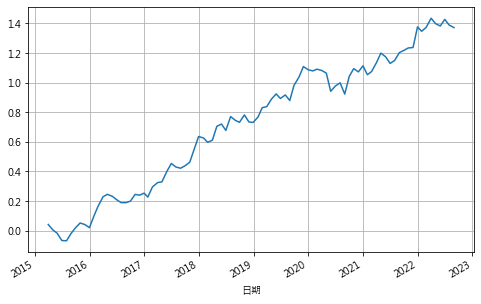

T值: 3.14, T值與樣本內差異: -0.72


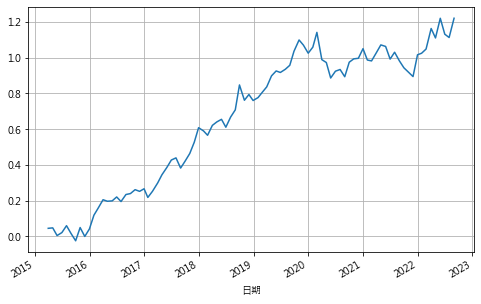

T值: 2.47, T值與樣本內差異: -0.20


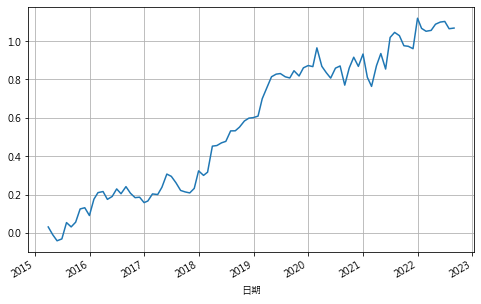

T值: 2.18, T值與樣本內差異: -0.09


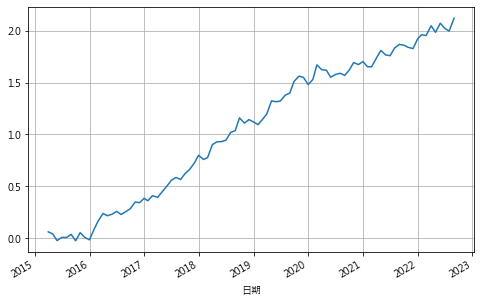

T值: 4.35, T值與樣本內差異: 0.75


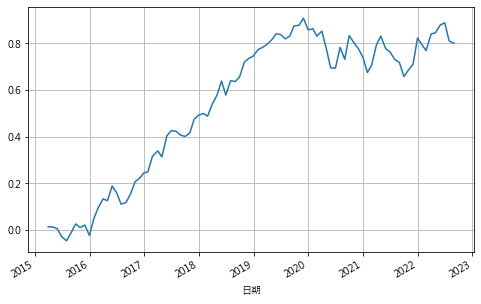

T值: 2.02, T值與樣本內差異: -0.53


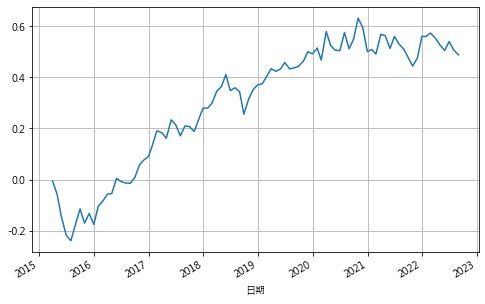

T值: 1.21, T值與樣本內差異: -1.48


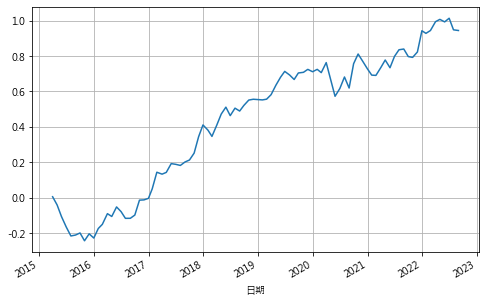

T值: 2.22, T值與樣本內差異: -1.59


In [22]:
# 分群計算
multifactor = dict()
for i in range(len(best_weights_list)):
    for k in factors.keys():
        multifactor[k] = factors[k] * best_weights_list[i][k]
    group_names = [str(x) for x in range(1, 51)]
    multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
    close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
    for c in close_m.columns:
        close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
    close_m = close_m.shift(-1)
    df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
    for idx, row in multifactor_m.iterrows():
        # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
        se = pd.Series(close_m.loc[idx, :] - 0.00550, name=idx)
        if len(row.dropna()) >= 5:
            df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 50, labels=group_names)).mean()
    # 買第五群(最高分) 賣第一群(最低分)
    pf = (df_group_results['50'] - df_group_results['1'])
    pf.cumsum().plot(figsize=(8, 5), grid=True)
    plt.show()
    print('T值: {:.2F}, T值與樣本內差異: {:.2F}'.format(t_stat(pf), t_stat(pf) - t_list[i]))



移動窗格最佳化

開始時間:  2022-10-04 15:46:55.826432
樣本內 2005 - 2008


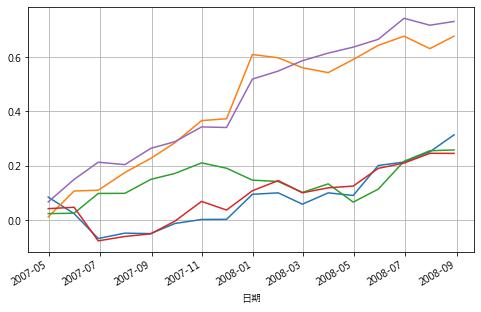

樣本外 2008 - 2012
T值平均差異: 0.36


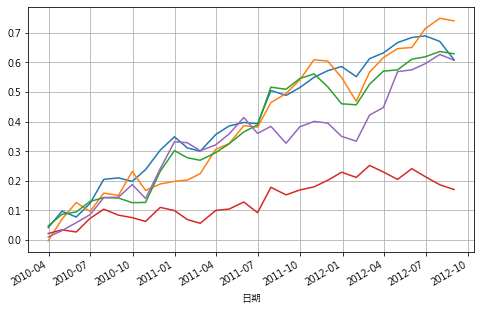


--------------------------------------------------

樣本內 2006 - 2009


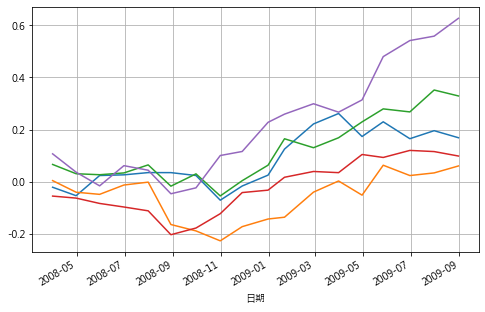

樣本外 2009 - 2013
T值平均差異: -0.53


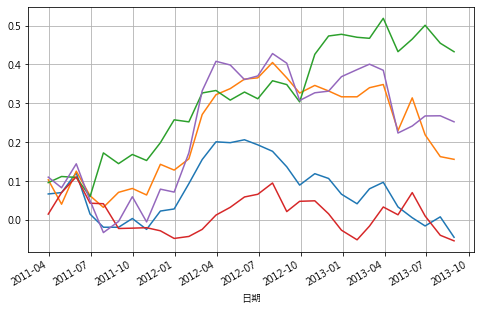


--------------------------------------------------

樣本內 2007 - 2010


KeyboardInterrupt: 

In [23]:
# 先放不用iter的物件
np.seterr(divide='ignore')
def t_stat(series):
    return series.mean() * np.sqrt(len(series.dropna())) / series.std()

print('開始時間: ', datetime.datetime.now())
for y in range(2005, 2022-6):
    print(f'樣本內 {y} - {y+3}')
    start = datetime.datetime(y, 9, 30)
    end = datetime.datetime(y+3, 9, 30)
    factor = Factor(pymongo.MongoClient(), start=start, end=end, db_name='Fields')
    factor.get_data(['開盤價', '最高價', '最低價', '還原收盤價', 'EPS_Q'], store=True)

    factors = {
        'EPS_Q': factor.create_to_daily(factor.get_norm_factor('EPS_Q', growth=True, growth_len=4)),
        '營業收入淨額_Y': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Y', growth=True)),
        '營業收入淨額_Q': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Q', growth=True, growth_len=4)),
        '殖利率': factor.get_norm_factor('殖利率'),
        '股價淨值比': factor.get_norm_factor('股價淨值比'),
        '本益比': factor.get_norm_factor('本益比(近四季)'),
        '成交金額(千)': factor.get_norm_factor('成交金額(千)'),
        '20MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(20).mean().pct_change()),
        '60MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(60).mean().pct_change()),
        '120MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(120).mean().pct_change()),
        '20STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(20).std()),
        '60STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(60).std()),
        '120STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(120).std())
    }
    close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
    for c in close_m.columns:
        close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
    close_m = close_m.shift(-1)
    best_ir = 0
    best_weights = dict()
    best_weights_list = list()
    pf_list = list()
    t_list = list()
    group_names = [str(x) for x in range(1, 51)]

    for _ in range(2000):
        weights = {
            'EPS_Q': np.random.choice([-1, 0, 1, 5]),
            '營業收入淨額_Y': np.random.choice([-1, 0, 1, 5]),
            '營業收入淨額_Q': np.random.choice([-1, 0, 1, 5]),
            '殖利率': np.random.choice([-1, 0, 1, 5]),
            '股價淨值比': np.random.choice([-5, -1, 0, 1]),
            '本益比': np.random.choice([-5, -1, 0, 1]),
            '成交金額(千)': np.random.choice([-1, 0, 1]),
            '20MA':  np.random.choice([-1, 0, 1, 5]),
            '60MA':  np.random.choice([-1, 0, 1, 5]),
            '120MA':  np.random.choice([-1, 0, 1, 5]),
            '20STD':  np.random.choice([-5, -1, 0, 1]),
            '60STD':  np.random.choice([-5, -1, 0, 1]),
            '120STD':  np.random.choice([-5, -1, 0, 1])
        }

        multifactor = dict()
        for k in factors.keys():
            multifactor[k] = factors[k] * weights[k]
        multifactor_m = sum(multifactor.values()).groupby(pd.Grouper(freq='1m')).tail(1)
        ic_multifactor = factor.get_ic(multifactor_m, pct_len=1, decay=1)
        ir = ic_multifactor.mean() / ic_multifactor.std()
        
        if ir > best_ir:
            best_ir = ir
            best_weights = weights
            best_weights_list.append(weights)
            # 分群計算
            #group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
            #group_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12' ,'13', '14', '15']
            multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
            df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
            for idx, row in multifactor_m.iterrows():
                # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
                se = pd.Series(close_m.loc[idx, :] - 0.00550, name=idx)
                if len(row.dropna()) >= 5:
                    df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 50, labels=group_names)).mean()
            # 買第五群(最高分) 賣第一群(最低分)
            pf = (df_group_results['50'] - df_group_results['1'])
            pf_list.append(pf.cumsum())#.plot(figsize=(8, 5), grid=True)
            t_ratio = t_stat(pf)
            t_list.append(t_ratio)
            sharpe_ratio = pf.mean() / pf.std()
            sharpe_ratio_cum = pf.cumsum().mean() / pf.cumsum().std()
            #df_group_results.cumsum().plot(figsize=(16, 9), grid=True)
    pf_list = pf_list[-5:]
    for pfl in pf_list:
        pfl.plot(figsize=(8, 5), grid=True)
    plt.show()
    best_weights_list = best_weights_list[-5:]
    t_list = t_list[-5:]
    # 樣本外
    print(f'樣本外 {y+3} - {y+7}')
    start = datetime.datetime(y+3, 9, 30)
    end = datetime.datetime(y+7, 9, 30)
    factor = Factor(pymongo.MongoClient(), start=start, end=end, db_name='Fields')
    factor.get_data(['開盤價', '最高價', '最低價', '還原收盤價', 'EPS_Q'], store=True)

    close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
    for c in close_m.columns:
        close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
    close_m = close_m.shift(-1)
    
    factors = {
        'EPS_Q': factor.create_to_daily(factor.get_norm_factor('EPS_Q', growth=True, growth_len=4)),
        '營業收入淨額_Y': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Y', growth=True)),
        '營業收入淨額_Q': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Q', growth=True, growth_len=4)),
        '殖利率': factor.get_norm_factor('殖利率'),
        '股價淨值比': factor.get_norm_factor('股價淨值比'),
        '本益比': factor.get_norm_factor('本益比(近四季)'),
        '成交金額(千)': factor.get_norm_factor('成交金額(千)'),
        '20MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(20).mean().pct_change()),
        '60MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(60).mean().pct_change()),
        '120MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(120).mean().pct_change()),
        '20STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(20).std()),
        '60STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(60).std()),
        '120STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(120).std())
    }
    # 分群計算
    multifactor = dict()
    t_diff = list()
    for i in range(len(best_weights_list)):
        for k in factors.keys():
            multifactor[k] = factors[k] * best_weights_list[i][k]
        group_names = [str(x) for x in range(1, 51)]
        multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
        close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
        for c in close_m.columns:
            close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
        close_m = close_m.shift(-1)
        df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
        for idx, row in multifactor_m.iterrows():
            # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
            se = pd.Series(close_m.loc[idx, :] - 0.00585, name=idx)
            if len(row.dropna()) >= 5:
                df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 50, labels=group_names)).mean()
        # 買第五群(最高分) 賣第一群(最低分)
        pf = (df_group_results['50'] - df_group_results['1'])
        pf.cumsum().plot(figsize=(8, 5), grid=True)
        t_diff.append(t_stat(pf) - t_list[i])
    print('T值平均差異: {:.2f}'.format(np.mean(t_diff)))
    plt.show()
    print('\n--------------------------------------------------\n')
print(datetime.datetime.now)


# 單一因子變動測試

開始時間:  2022-10-04 16:51:00.603218
樣本內 2005 - 2008


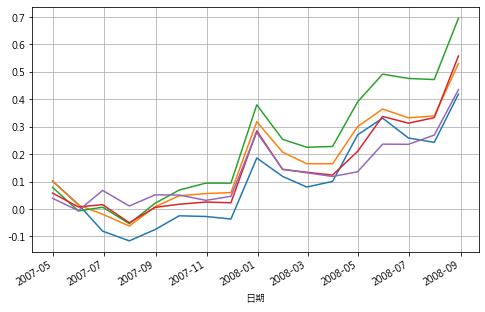

樣本外 2008 - 2012
T值平均差異: 0.61


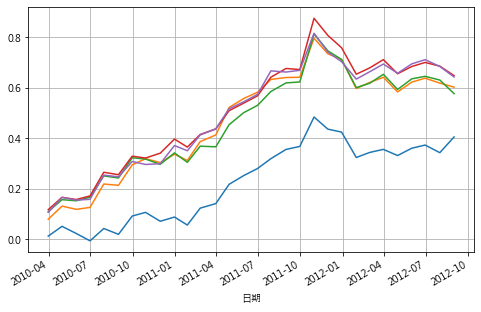


--------------------------------------------------

樣本內 2006 - 2009


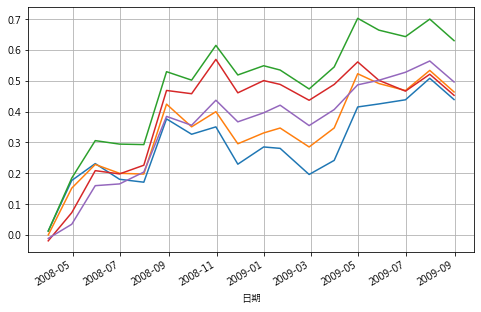

樣本外 2009 - 2013
T值平均差異: -0.65


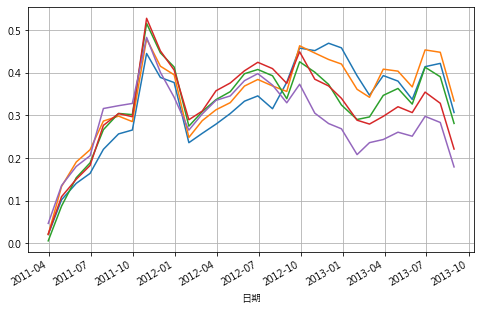


--------------------------------------------------

樣本內 2007 - 2010


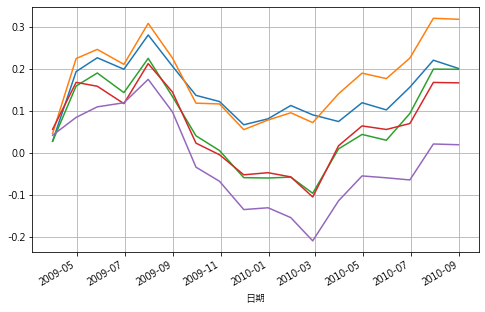

樣本外 2010 - 2014
T值平均差異: -0.48


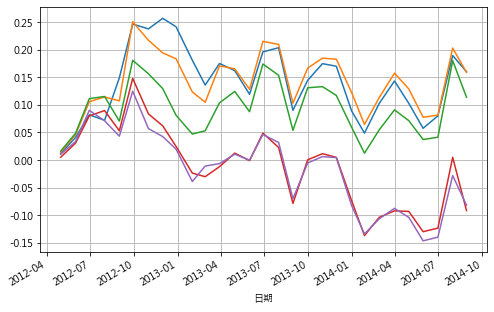


--------------------------------------------------

樣本內 2008 - 2011


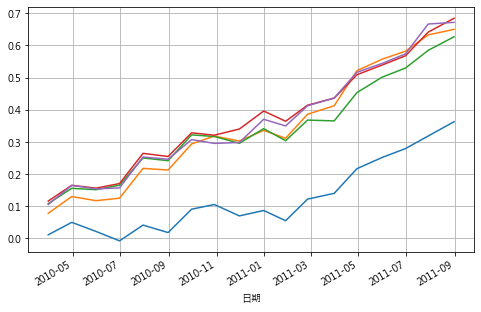

樣本外 2011 - 2015
T值平均差異: -3.07


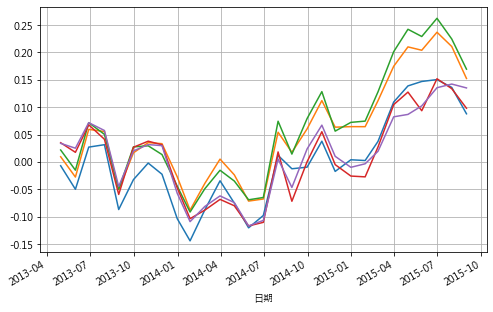


--------------------------------------------------

樣本內 2009 - 2012


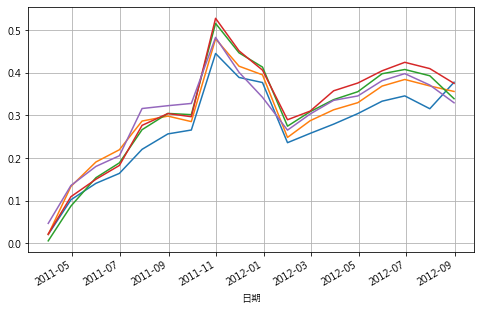

樣本外 2012 - 2016
T值平均差異: 0.25


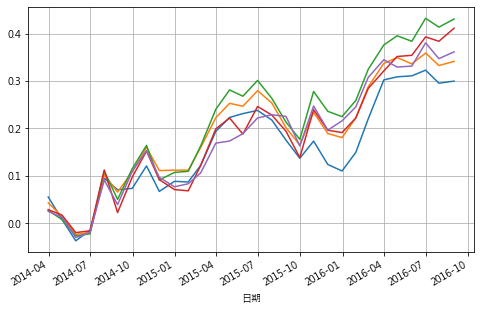


--------------------------------------------------

樣本內 2010 - 2013


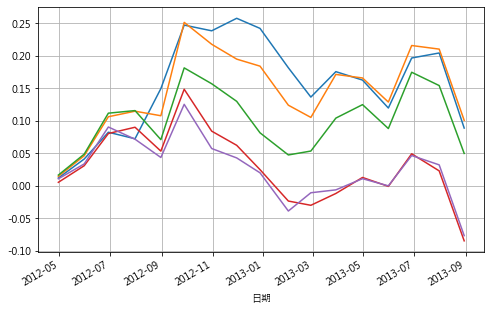

樣本外 2013 - 2017
T值平均差異: 1.48


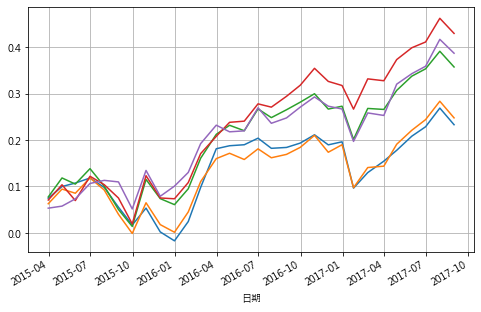


--------------------------------------------------

樣本內 2011 - 2014


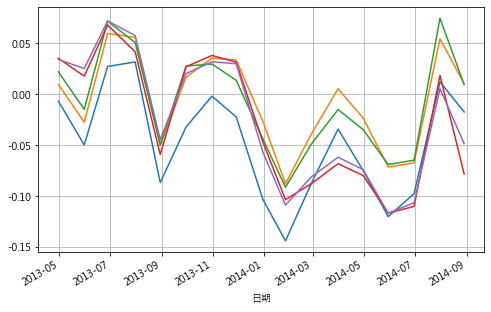

樣本外 2014 - 2018
T值平均差異: 1.85


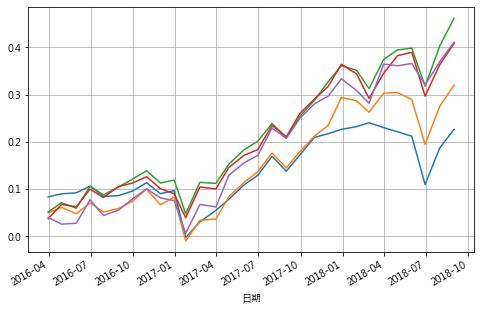


--------------------------------------------------

樣本內 2012 - 2015


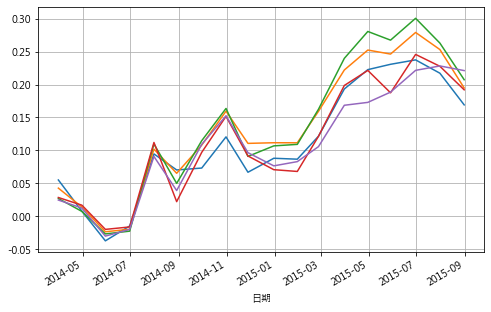

樣本外 2015 - 2019
T值平均差異: 0.86


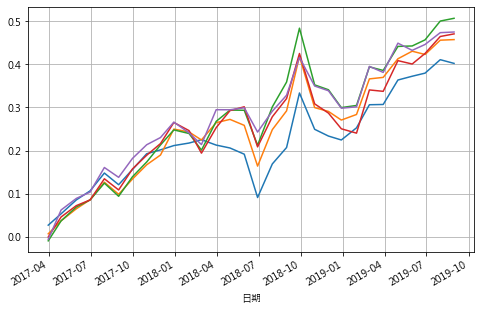


--------------------------------------------------

樣本內 2013 - 2016


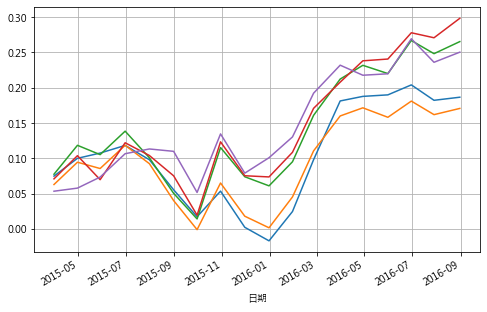

樣本外 2016 - 2020
T值平均差異: -0.69


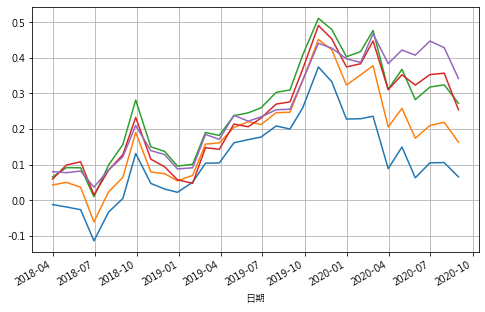


--------------------------------------------------

樣本內 2014 - 2017


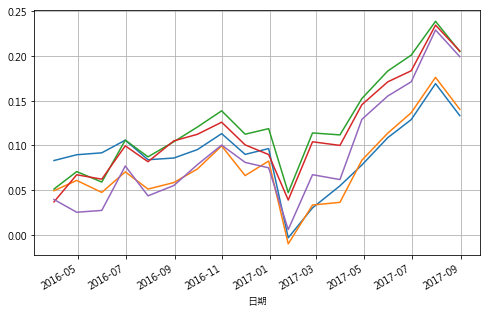

樣本外 2017 - 2021
T值平均差異: -1.01


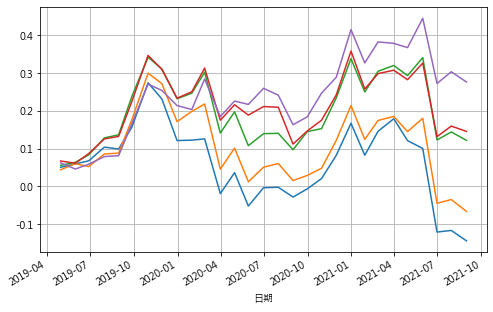


--------------------------------------------------

樣本內 2015 - 2018


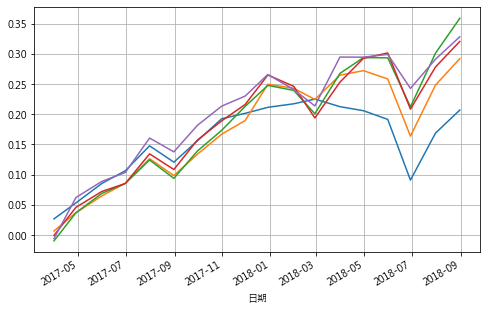

樣本外 2018 - 2022
T值平均差異: -2.33


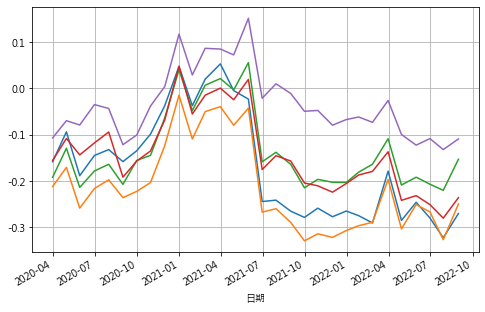


--------------------------------------------------

<built-in method now of type object at 0x00007FFBA3DBB650>


In [5]:
np.seterr(divide='ignore')
def t_stat(series):
    return series.mean() * np.sqrt(len(series.dropna())) / series.std()
print('開始時間: ', datetime.datetime.now())
for y in range(2005, 2022-6):
    print(f'樣本內 {y} - {y+3}')
    start = datetime.datetime(y, 9, 30)
    end = datetime.datetime(y+3, 9, 30)
    factor = Factor(pymongo.MongoClient(), start=start, end=end, db_name='Fields')
    factor.get_data(['開盤價', '最高價', '最低價', '還原收盤價', 'EPS_Q'], store=True)

    factors = {
        'EPS_Q': factor.create_to_daily(factor.get_norm_factor('EPS_Q', growth=True, growth_len=4)),
        '營業收入淨額_Y': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Y', growth=True)),
        '營業收入淨額_Q': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Q', growth=True, growth_len=4)),
        '殖利率': factor.get_norm_factor('殖利率'),
        '股價淨值比': factor.get_norm_factor('股價淨值比'),
        '本益比': factor.get_norm_factor('本益比(近四季)'),
        '成交金額(千)': factor.get_norm_factor('成交金額(千)'),
        '20MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(20).mean().pct_change()),
        '60MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(60).mean().pct_change()),
        '120MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(120).mean().pct_change()),
        '20STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(20).std()),
        '60STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(60).std()),
        '120STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(120).std())
    }
    close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
    for c in close_m.columns:
        close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
    close_m = close_m.shift(-1)
    best_ir = 0
    best_weights = dict()
    best_weights_list = list()
    pf_list = list()
    t_list = list()
    group_names = [str(x) for x in range(1, 51)]

    for choice in range(-2, 3):
        weights = {
            'EPS_Q': choice,
            '營業收入淨額_Y': 1,
            '營業收入淨額_Q': 1,
            '殖利率': 1,
            '股價淨值比': -1,
            '本益比': -1,
            '成交金額(千)': 1,
            '20MA':  1,
            '60MA':  1,
            '120MA':  1,
            '20STD':  -1,
            '60STD':  -1,
            '120STD':  -1
        }

        multifactor = dict()
        for k in factors.keys():
            multifactor[k] = factors[k] * weights[k]
        multifactor_m = sum(multifactor.values()).groupby(pd.Grouper(freq='1m')).tail(1)
        ic_multifactor = factor.get_ic(multifactor_m, pct_len=1, decay=1)
        ir = ic_multifactor.mean() / ic_multifactor.std()
        best_weights_list.append(weights)

        multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
        df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
        for idx, row in multifactor_m.iterrows():
            # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
            se = pd.Series(close_m.loc[idx, :] - 0.00550, name=idx)
            if len(row.dropna()) >= 5:
                df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 50, labels=group_names)).mean()
        # 買第五群(最高分) 賣第一群(最低分)
        pf = (df_group_results['50'] - df_group_results['1'])
        pf_list.append(pf.cumsum())#.plot(figsize=(8, 5), grid=True)
        t_ratio = t_stat(pf)
        t_list.append(t_ratio)
        sharpe_ratio = pf.mean() / pf.std()
        sharpe_ratio_cum = pf.cumsum().mean() / pf.cumsum().std()
            #df_group_results.cumsum().plot(figsize=(16, 9), grid=True)
    for pfl in pf_list:
        pfl.plot(figsize=(8, 5), grid=True)
    plt.show()

    # 樣本外
    print(f'樣本外 {y+3} - {y+7}')
    start = datetime.datetime(y+3, 9, 30)
    end = datetime.datetime(y+7, 9, 30)
    factor = Factor(pymongo.MongoClient(), start=start, end=end, db_name='Fields')
    factor.get_data(['開盤價', '最高價', '最低價', '還原收盤價', 'EPS_Q'], store=True)

    close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
    for c in close_m.columns:
        close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
    close_m = close_m.shift(-1)
    
    factors = {
        'EPS_Q': factor.create_to_daily(factor.get_norm_factor('EPS_Q', growth=True, growth_len=4)),
        '營業收入淨額_Y': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Y', growth=True)),
        '營業收入淨額_Q': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Q', growth=True, growth_len=4)),
        '殖利率': factor.get_norm_factor('殖利率'),
        '股價淨值比': factor.get_norm_factor('股價淨值比'),
        '本益比': factor.get_norm_factor('本益比(近四季)'),
        '成交金額(千)': factor.get_norm_factor('成交金額(千)'),
        '20MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(20).mean().pct_change()),
        '60MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(60).mean().pct_change()),
        '120MA': factor.get_norm_factor(factor.data['還原收盤價'].rolling(120).mean().pct_change()),
        '20STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(20).std()),
        '60STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(60).std()),
        '120STD': factor.get_norm_factor(factor.data['還原收盤價'].pct_change().rolling(120).std())
    }
    # 分群計算
    multifactor = dict()
    t_diff = list()
    for i in range(len(best_weights_list)):
        for k in factors.keys():
            multifactor[k] = factors[k] * best_weights_list[i][k]
        group_names = [str(x) for x in range(1, 51)]
        multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
        close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)#.pct_change().shift(-1)
        for c in close_m.columns:
            close_m.loc[:, c] = np.log(close_m.loc[:, c]) - np.log(close_m.loc[:, c].shift(1))
        close_m = close_m.shift(-1)
        df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
        for idx, row in multifactor_m.iterrows():
            # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
            se = pd.Series(close_m.loc[idx, :] - 0.00585, name=idx)
            if len(row.dropna()) >= 5:
                df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 50, labels=group_names)).mean()
        # 買第五群(最高分) 賣第一群(最低分)
        pf = (df_group_results['50'] - df_group_results['1'])
        pf.cumsum().plot(figsize=(8, 5), grid=True)
        t_diff.append(t_stat(pf) - t_list[i])
    print('T值平均差異: {:.2f}'.format(np.mean(t_diff)))
    plt.show()
    print('\n--------------------------------------------------\n')
print(datetime.datetime.now)


綠紅橘紫藍
[u'b', u'g', u'r', u'c', u'm'
藍 橘 綠 紅 紫